In [4]:
pip install torch

     |████████████████████████████████| 881.9 MB 7.4 kB/s              ��█████████████▌             | 510.4 MB 110.4 MB/s eta 0:00:04
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow

     |████████████████████████████████| 458.3 MB 9.2 kB/s              MB/s eta 0:00:01��███████▏ | 432.3 MB 92.9 MB/s eta 0:00:01 0:00:01 
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 1.3 MB 79.7 MB/s            
     |████████████████████████████████| 4.5 MB 23.6 MB/s            
     |████████████████████████████████| 5.6 MB 56.6 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 42 kB 2.2 MB/s             
     |████████████████████████████████| 65 kB 7.0 MB/s             
     |████████████████████████████████| 132 kB 97.0 MB/s            
     |████████████████████████████████| 462 kB 100.8 MB/s            
     |████████████████████████████████| 152 kB 65.4 MB/s            
     |████████████████████████████████| 97 kB 12.6 MB/s            
     |████████████████████████████████| 4.9 MB 77.7 MB/s            
     |████████████████████████████████| 781 kB 49.0 MB/s            
     |███████████████

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylint 2.12.2 requires typing-extensions>=3.10.0; python_version < "3.10", but you have typing-extensions 3.7.4.3 which is incompatible.
astroid 2.9.0 requires typing-extensions>=3.10; python_version < "3.10", but you have typing-extensions 3.7.4.3 which is incompatible.
aiobotocore 1.3.0 requires botocore<1.20.50,>=1.20.49, but you have botocore 1.24.42 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [53]:
import torch
import torch.nn as nn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.run_functions_eagerly(True)
from sklearn.utils import class_weight
from sklearn.metrics import mean_squared_error

import datetime

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
df = pd.read_csv('../Data/Full_train_test_split/df_full_end_test.csv')
df = df.drop(columns = ["Unnamed: 0", "1_hr_std","2_hr_std","3_hr_std", "4_hr_std", "standardised_texts","2_hr","1_hr"])

In [28]:
df['chunk'] = pd.to_datetime(df['chunk'], format="%Y-%m-%d %H:%M:%S")
df['hour'] = df['chunk'].dt.hour
df['weekday'] = df['chunk'].dt.dayofweek
df['weekday'] = df['weekday'].astype("category")
df = df.set_index('chunk')
df["abnormal"] = df["abnormal"].astype('int')
df.head()

,texts,temp_weighted,cloud_cover_weighted,rainfall_weighted,abnormal,polarity,3_hr,4_hr,daily_policy_index,train_test,hour,weekday
chunk,,,,,,,,,,,,
2018-10-25 19:00:00,57,10.409742,73.715648,0.016261,0,0.064641,16,14,196.24,train,19,3
2018-10-25 20:00:00,102,10.386005,75.509971,0.014549,0,0.064641,44,16,196.24,train,20,3
2018-10-25 21:00:00,99,10.134989,81.518421,0.017371,0,0.064641,37,44,196.24,train,21,3
2018-10-25 22:00:00,88,9.803373,80.854104,0.006652,0,0.064641,57,37,196.24,train,22,3
2018-10-25 23:00:00,73,9.872040,83.125380,0.002621,0,0.064641,102,57,196.24,train,23,3


In [112]:
len(df)

31682

In [44]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss_y = StandardScaler()

train = df.loc[df['train_test'] == "train"]
train = train.drop(columns = ["train_test"])
train = train.astype('float')
test = df.loc[df['train_test'] == "test"]
train = train.astype('float')
test = test.drop(columns = ["train_test"])

y_train = train.iloc[:, 0:1] 
X_train = train
X_train = X_train.drop(columns = ["abnormal", "texts"])

y_test = test.iloc[:, 0:1] 
X_test = test
X_test = X_test.drop(columns = ["abnormal", "texts"])

X_train = ss.fit_transform(X_train)
y_train = ss_y.fit_transform(y_train)
#y_train = y_train.to_numpy()
X_test = ss.transform(X_test)
y_test = ss_y.transform(y_test)
#y_test = y_test.to_numpy()


In [45]:
X_train

array([[-5.51881121e-02,  1.11781152e+00, -4.51298350e-01, ...,
        -4.62302402e-01,  1.08323079e+00, -4.12114438e-04],
       [-5.95733121e-02,  1.19849523e+00, -4.57447450e-01, ...,
        -4.62302402e-01,  1.22768641e+00, -4.12114438e-04],
       [-1.05945991e-01,  1.46867179e+00, -4.47308587e-01, ...,
        -4.62302402e-01,  1.37214202e+00, -4.12114438e-04],
       ...,
       [ 3.23043577e-01,  1.27894930e+00, -3.53644407e-01, ...,
         4.05988891e-01,  1.22768641e+00,  4.99787306e-01],
       [ 2.69069105e-01,  1.42600662e+00, -4.15595759e-01, ...,
         4.05988891e-01,  1.37214202e+00,  4.99787306e-01],
       [ 2.78718906e-01,  1.08357424e+00, -5.09714792e-01, ...,
         4.05988891e-01,  1.51659763e+00,  4.99787306e-01]])

In [46]:
X_val = X_train[24000: , :]
y_val = y_train[24000: , :]
X_train = X_train[:-3916 , :]
y_train = y_train[:-3916 , :]

In [88]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 
print("Validation Shape", X_val.shape, y_val.shape)

Training Shape (24000, 9) (24000, 1)
Testing Shape (3766, 9) (3766, 1)
Validation Shape (3916, 9) (3916, 1)


In [102]:
model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(34, input_shape=(1,9),return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(24*9,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Dense(1,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    #tf.keras.layers.Reshape([1, 1])
])


In [103]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.metrics.MeanAbsoluteError()])

In [104]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 34)                5984      
_________________________________________________________________
dense_10 (Dense)             (None, 216)               7560      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 217       
Total params: 13,761
Trainable params: 13,761
Non-trainable params: 0
_________________________________________________________________


In [105]:
#class_weight = {0: 0.5, 1: 50}

In [124]:
model.fit(X_train.reshape(-1,1,9), y_train,
          validation_data=(X_val.reshape(-1,1,9), y_val), epochs = 100, batch_size=72)

Epoch 1/100
  4/334 [..............................] - ETA: 8s - loss: 0.9876 - mean_absolute_error: 0.7657 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


334/334 [==============================] - 7s 19ms/step - loss: 0.9022 - mean_absolute_error: 0.7242 - val_loss: 1.6715 - val_mean_absolute_error: 0.9435
Epoch 2/100
334/334 [==============================] - 6s 17ms/step - loss: 0.9005 - mean_absolute_error: 0.7171 - val_loss: 1.6735 - val_mean_absolute_error: 0.9441
Epoch 3/100
334/334 [==============================] - 7s 21ms/step - loss: 0.9005 - mean_absolute_error: 0.7164 - val_loss: 1.6682 - val_mean_absolute_error: 0.9426
Epoch 4/100
334/334 [==============================] - 6s 19ms/step - loss: 0.9005 - mean_absolute_error: 0.7165 - val_loss: 1.6728 - val_mean_absolute_error: 0.9439
Epoch 5/100
334/334 [==============================] - 7s 20ms/step - loss: 0.9005 - mean_absolute_error: 0.7174 - val_loss: 1.6773 - val_mean_absolute_error: 0.9451
Epoch 6/100
334/334 [==============================] - 7s 21ms/step - loss: 0.9005 - mean_absolute_error: 0.7169 - val_loss: 1.6811 - val_mean_absolute_error: 0.9462
Epoch 7/100
334/

334/334 [==============================] - 7s 20ms/step - loss: 0.9005 - mean_absolute_error: 0.7164 - val_loss: 1.6724 - val_mean_absolute_error: 0.9438
Epoch 51/100
334/334 [==============================] - 6s 17ms/step - loss: 0.9005 - mean_absolute_error: 0.7169 - val_loss: 1.6807 - val_mean_absolute_error: 0.9461
Epoch 52/100
334/334 [==============================] - 7s 20ms/step - loss: 0.9005 - mean_absolute_error: 0.7161 - val_loss: 1.6742 - val_mean_absolute_error: 0.9443
Epoch 53/100
334/334 [==============================] - 6s 19ms/step - loss: 0.9005 - mean_absolute_error: 0.7165 - val_loss: 1.6763 - val_mean_absolute_error: 0.9449
Epoch 54/100
334/334 [==============================] - 6s 19ms/step - loss: 0.9005 - mean_absolute_error: 0.7172 - val_loss: 1.6778 - val_mean_absolute_error: 0.9453
Epoch 55/100
334/334 [==============================] - 6s 18ms/step - loss: 0.9005 - mean_absolute_error: 0.7169 - val_loss: 1.6820 - val_mean_absolute_error: 0.9464
Epoch 56/10

KeyboardInterrupt: 

In [127]:
trainPredict = model.predict(X_train.reshape(-1,1,9))
testPredict = model.predict(X_test.reshape(-1,1,9))
valPredict = model.predict(X_val.reshape(-1,1,9))
# invert predictions
trainPredict = ss_y.inverse_transform(trainPredict)
trainY = ss_y.inverse_transform([y_train])
testPredict = ss_y.inverse_transform(testPredict)
testY = ss_y.inverse_transform([y_test])
valPredict = ss_y.inverse_transform(valPredict)
valY = ss_y.inverse_transform([y_val])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 123.61 RMSE
Test Score: 248.64 RMSE


In [85]:
trainPredict

array([[146.13475],
       [146.13475],
       [146.13475],
       ...,
       [146.13475],
       [146.13475],
       [146.13475]], dtype=float32)

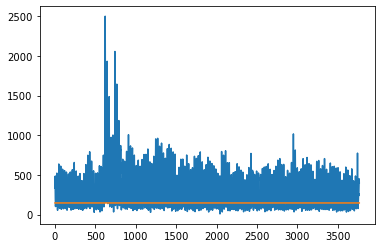

In [123]:
#trainPredictPlot = [np.nan for x in range(31682)]  # N = size of list you want
#trainPredictPlot[4:len(trainPredict)+4] = trainPredict

# shift test predictions for plotting
#testPredictPlot = [np.nan for x in range(31682)] 
#testPredictPlot[27916:len(df)] = testPredict

# plot baseline and predictions
plt.plot((df['texts'][27916:len(df)].astype(float).to_numpy()))
#plt.plot(trainPredictPlot)
plt.plot(testPredict)
plt.show()